In [6]:
import numpy as np
import tensorflow as tf
import sys
import os
import matplotlib.pyplot as plt
import matplotlib, re
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,6)
import json

In [2]:
#coding:utf-8


import numpy as np
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import matplotlib, re
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,6)
import json


class LSTM():
    def init_variables(self):
        self.input_train = None
        self.label_train = None
        self.input_test  = None
        self.label_test  = None
        
        self.input_placeholder = None
        self.label_placeholder = None
        
        self.complete_model = None
        
        self.loss  = None
        self.train = None
        
        self.dummy_data = [[0]*self.config.input_dimension]
        self.dummy_label = [[0]*self.config.label_dimension]
        
        self.n_input = 0
        
        self.embedding = None
        self.w2i = None
        self.i2w = None
        
        self.hot_one = np.eye( self.config.label_dimension ,dtype='int').tolist()
        
        #Chargement de l'embedding
        if self.config.bool_create_embedding and self.config.bool_load_embedding:
            raise "Il faut choisir entre générer l'mebedding aléatoirement ou bien le charger"
            
        if self.config.bool_load_embedding:
            x,y = self.config.vocabsize, self.config.input_dimension
            
            emb = []
            with open(self.config.filename+'.embedding','r') as f:
                for l in f.readlines():
                    tmp = l.split()
                    tmp = [float(v) for v in tmp]
                    emb.append(tmp)

            #Vérification de la taille
            if len(emb) != x or len(emb[0]) != y:
                raise "Taille de l'embedding chargée non compatible avec la taille du vocabulaire et de la dimension d'entrée"
            self.embedding = emb
        
        else:            
            if self.config.bool_create_embedding:
                #Xavier-initialization: tirage uniforme sur -p,p avec p=sqrt(6/(x+y))
                p = (6./(x+y))**0.5
                self.embedding = np.random.uniform(-p,p, size=(x,y)).tolist()    
            
            
    def load_data(self):
        """
        Fonction:
            Charge les données qui sont sous la forme {"data": ... ,"label": ... } obtenu par un json.dumps dans
            filename.data
        
        Args:
            Aucun
        Returns:
            Aucun
            
        Remarques:
            - La configuration se fait via Config():
                > bool_w2i = True         : "data" est une liste de mots PRESENTS dans le fichier .w2i chargé
                                             Les mots sont alors convertis en l'index associé
                > bool_embedding = True   : Les entrées sont mappées sur l'embedding du fichier .embedding
                > ratio                   : Détermine le ratio train/test
                
            - "label" peut être de 3 types différents:
                > int      : label est alors utilisé à chaque timestep de la LSTM
                > list int : list est de taille le nombre de sorties de la LSTM
                > list str : si bool_w2i == True alors comme pour "data" les labels sont convertis en l'index associé
               
        """
        
        input_ = []
        label_ = []
        
        with open(self.config.filename+".data", "r") as f:
            for l in f.readlines():
                tmp = json.loads(l)                
                data, label = tmp['data'], tmp['label']                
                
                #Traitement des différents types de label
                if type(label) == int:
                    label = [self.hot_one[label]]*len(data)
                elif type(label[0]) == int:
                    label = [self.hot_one[i] for i in label]
                else:
                    if self.config.bool_w2i:
                        label = [self.hot_one[self.w2i[i]] for i in label]
                    else:
                        raise "Impossible de décrypter les labels"
                
                
                if self.config.bool_w2i:
                    data = [self.w2i[w] for w in data]
                    
                if self.embedding is not None:
                    data = [self.embedding[i] for i in data]
                
                #Complétion des data/label pour la structure LSTM masquée de tensorflow
                data, label = self.feed_utils_complete(data, label)
                                
                input_.append(data)
                label_.append(label)
               
        
        nb = int(self.config.ratio*len(input_))
        self.n_input = nb
        
        #Répartition train/test
        self.input_train = input_[:nb]
        self.label_train = label_[:nb]
        self.input_test = input_[nb:]
        self.label_test = label_[nb:]
        
        
        
                
    def add_placeholder(self):
        self.input_placeholder = tf.placeholder(tf.float32, shape=(None, self.config.sequencesize, self.config.input_dimension))
        self.label_placeholder = tf.placeholder(tf.float32, shape=(None, self.config.sequencesize, self.config.label_dimension))
    
    def create_feed_dict(self,input_batch,label_batch=None):
        feed = {self.input_placeholder: input_batch}
        if label_batch is not None:
            feed[self.label_placeholder] = label_batch
            
        return feed
    
    def add_model(self):
        """
        Fonction:
            Crée le modèle LSTM ainsi que la projection de sortie dans le 'computing graph'
        
        Args:
            Aucun
        Returns:
            Aucun
            
        Remarques:
            Aucunes
        """
        
        with tf.variable_scope("LSTM") as scope:
            cell = tf.nn.rnn_cell.LSTMCell(self.config.hidden_dimension)
            
            #cell = tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=0.95, input_keep_prob=0.95)
            
            l = self.feed_utils_length(self.input_placeholder)
            LSTMmodel, _ = tf.nn.dynamic_rnn(cell, self.input_placeholder, dtype=tf.float32,sequence_length=l)
            #LSTMmodel est un tenseur de taille (batchsize, sequencesize, hidden_dimension)
        
        with tf.variable_scope("output") as scope:
            lstm_outputs = tf.unpack(LSTMmodel, axis=1)
            
            W = tf.get_variable('W', shape=(self.config.hidden_dimension, self.config.label_dimension), dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())
            b = tf.get_variable('b', shape=(self.config.label_dimension), dtype=tf.float32, initializer=tf.constant_initializer())
            
            complete_model = [tf.nn.softmax( tf.matmul(ten, W) + b ) for ten in lstm_outputs]
        
        self.complete_model = complete_model
        #self.predictions = [tf.argmax(t,1) for t in self.complete_model]
    
    def add_loss_op(self):
        #ones = tf.ones(shape=(self.config.batchsize))
        #loss = tf.nn.seq2seq.sequence_loss(self.complete_model, tf.unpack(self.label_placeholder,axis=1), [ones for _ in range(self.config.sequencesize)] )
        
        lab = tf.unpack(self.label_placeholder, axis=1)
        
        
        """Après 1000 essais différents de loss, je suis venu aux conclusions suivantes
        
            - Il ne faut pas prendre en compte les décisions sur les premiers mots, qui restent peu sures
            - Il faut donner plus d'importance aux décisions sur les derniers mots
            
            D'où une loss proportionnelle qui commence à partir du 4ème mot ... 
            (la puissance 1.5 est totalement gratuite mais cela accentue l'importance des mots de la fin sans écraser le reste comme le ferait un carré)
        
        """
        debut = 4
                
        loss = - tf.reduce_sum( tf.log(self.complete_model[debut])*lab[debut])
        for i in range(debut+1,self.config.sequencesize):
            loss += - (i-debut)**1.5*tf.reduce_sum( tf.log(self.complete_model[i])*lab[i])
            
        self.loss = loss
        
    def add_training_op(self):
        train = tf.train.AdamOptimizer(self.config.lr).minimize(self.loss)
        self.train = train
    
    def run_epoch(self, sess):
        nb_batch = self.n_input // self.config.batchsize
        
        losses = []
        
        for i in range(nb_batch):
            batch = [self.input_train[j] for j in range(i*self.config.batchsize, (i+1)*self.config.batchsize)]
            label = [self.label_train[j] for j in range(i*self.config.batchsize, (i+1)*self.config.batchsize)]
            
            
            feed_dict = self.create_feed_dict(batch,label)
            _, loss = sess.run([self.train, self.loss], feed_dict=feed_dict)
            losses.append(loss)
            
            
            #print "\r%4d / %d : %f"%(i,nb_batch,np.exp(np.mean(losses)/self.config.batchsize/self.config.sequencesize)),
        
        return np.mean(losses)
    
    def feed_utils_complete(self, data, label=None):
        d = self.config.sequencesize - len(data)
        if label is None:
            return data + d*self.dummy_data
        else:
            return data + d*self.dummy_data, label + d*self.dummy_label
        
    
    def feed_utils_length(self, sequences):
        """
        Fonction:
            Calcule la 'vraie' longueur des séquences pour chaque élément du batch (qui a potentiellement été
            artificiellement remplis avec des vecteurs nuls)
        
        Args:
            - (batchsize, sequencesize, inputsize)-Tenseur
        Returns:
            - 1-D Tenseur de taille batchsize contenant la 'vraie' longueur de chaque élément
            
        Remarques:
        """
        
        return tf.cast(tf.reduce_sum(tf.sign(tf.reduce_max(tf.abs(sequences), reduction_indices=2)), reduction_indices=1), tf.int32)
        
        
        
    def fit(self, sess=None,log=True):
        if sess is None:
            sess = self.session
        
        for epoch in range(self.config.nb_epoch):
            loss = self.run_epoch(sess)
            if log:
                print "\rEpoch %4d : %4.2f"%(epoch, loss),
        
        return loss
        
    def predict(self, dataset):
        
        if dataset == 'train':
            inputs = self.input_train
        elif dataset == 'test':
            inputs = self.input_test
        else:
            tmp = json.loads(dataset)
            data = tmp['data']
        
            
            if self.embedding is not None:
                data = [self.embedding[i] for i in data]
            
            inputs = [self.feed_utils_complete(data)]        
        
        #p = np.array(self.session.run(self.predictions, feed_dict=self.create_feed_dict(inputs))).T
        p = self.session.run(self.complete_model, feed_dict={self.input_placeholder:inputs} )
        p = np.array(p).transpose([1,0,2])
        #p = np.argmax(np.sum(p[:,-3:,:]*np.array([[i*i] for i in range(1,4)]),axis=1),axis=1)
        #p = np.argmax(np.sum(p,axis=1),axis=1)
        p = np.argmax(np.sum(p*np.array([[i] for i in np.linspace(1,2,p.shape[1])]),axis=1),axis=1)
        
        return p
        
     
    def confusion(self,dataset='test'):
        """
        Fonction:
            Calcule la matrice de confusion (non normalisée) de la LSTM
        
        Args:
            - str dataset: dataset utilisé pour les prédictions: 'train' ou 'test'
        Returns:
            - Matrice de confusion
            
        Remarques:
            Matrice de confusion:
                    _______________________________________________..._____________
                    |GroundTruth\Prediction| Classe 1 | Classe 2 | ... | Classe n |
                    |______________________|__________|__________|_..._|__________|
                    |      Classe 1        |   c_11   |   c_12   | ... |   c_1n   |
                    |______________________|__________|__________|_..._|__________|
                    |      Classe 2        |   c_21   |   c_22   | ... |   c_2n   |
                    |______________________|__________|__________|_..._|__________|
                    ⋮                      ⋮          ⋮          ⋮     ⋮          ⋮
                    ⋮______________________⋮__________⋮__________⋮_..._⋮__________⋮
                    |      Classe n        |   c_n1   |   c_n2   | ... |   c_nn   |
                    |______________________|__________|__________|_..._|__________|
                    
                    
                    c_ij = nombre d'exemples de la classe i classifiés comme étant de la classe j            
        """
        
        
        if dataset == 'train':
            inputs = self.input_train
            labels = [np.argmax(l[0]) for l in self.label_train]
        else:
            inputs = self.input_test
            labels = [np.argmax(l[0]) for l in self.label_test]
        
        pred = self.predict(dataset)
        
        confusion = np.zeros((self.config.label_dimension,self.config.label_dimension))
        
        for k in range(len(pred)):
            i = labels[k]
            j = pred[k]
            confusion[i,j] += 1
            
        return confusion
        
        
    def __init__(self, config=None):
        if config is None:
            self.config = Config()
        else:
            self.config = config
        
        self.init_variables()
       
        self.load_data()
        self.add_placeholder()
        self.add_model()
        self.add_loss_op()
        self.add_training_op()
        
        self.session = tf.Session()
        self.session.run(tf.initialize_all_variables())
        

In [3]:
class Config():
    def __init__(
        self, 
        
        filename = "",
        
        lr=0.01,
        seq = 10, 
        ratio=0.1, 
        
        bool_create_embedding = False,
        bool_load_embedding = False,
        bool_w2i = False,
        vocabsize=0,
        label_dimension=0,
        input_dimension = 20,
        hidden_dimension = 40,
        
        nb_epoch=100,
        batchsize = 256
    ):
        
        self.lr = lr
        
        self.hidden_dimension = hidden_dimension
        self.input_dimension = input_dimension
        
        self.sequencesize = seq
        self.batchsize = batchsize
        self.label_dimension = label_dimension
        
        self.filename = filename
        
        self.nb_epoch = nb_epoch
        self.ratio = ratio
        
        self.bool_create_embedding = bool_create_embedding
        self.bool_load_embedding = bool_load_embedding
        self.bool_w2i = bool_w2i
        self.vocabsize = vocabsize

In [12]:
class LSTM_wrapper():
    
    def load_w2i(self, filename):
        self.word2index = dict()
        self.index2word = []
        with open(filename+".w2i",'r') as f:
            i=0
            for l in f.readlines():
                self.word2index[l.strip()] = i
                self.index2word.append(l.strip())
                i+=1
                
    def load_config(self,filename):
        with open(filename+".config") as f:
            self.configfile = json.load(f)
        
        self.config = Config(
                                filename=filename,
                                lr=0.0005,
                                seq=self.configfile['sequencesize'],
                                ratio=0.9,
                                bool_create_embedding = False,
                                bool_load_embedding = True,
                                bool_w2i = False,
                                vocabsize=self.configfile['vocabsize'],
                                label_dimension=self.configfile['label_dimension'],
                                input_dimension=self.configfile['input_dimension'],
                                hidden_dimension=int(self.configfile['input_dimension']*1.3),
                                nb_epoch=10) 
        
    def __init__(self, filename):
        self.load_config(filename)
        self.load_w2i(filename)
               
              
        #Grosse bidouille pour avoir la fin de chaine sans le path
        #name = filename[-filename[::-1].find('/'):]
        name = filename.split('/')[-1]
        with tf.variable_scope(name):
            self.lstm = LSTM(self.config)
        
    def encrypt(self, s):
        res=[]
        for w in s.split():
            res.append(self.word2index[w])
        return res
    
    def decrypt(self,s):
        res = []
        for i in s:
            res.append(self.index2word[i])
            
        return ' '.join(res)
    
    def predict(self, s):
        return [self.configfile['label_name'][i] for i in self.lstm.predict(json.dumps({'data':self.encrypt(s)}))[0][:len(s.split())]]
        
    def show_training(self, nb_epoch=2, nb_times=10):
        self.lstm.config.nb_epoch = nb_epoch
        
        label_test = self.lstm.label_test
        seq_len = [np.sum(l) for l in label_test]
        label_test = np.array([np.argmax(l[0]) for l in label_test])
                    
        for i in range(nb_times):
            self.lstm.fit()
            #p = self.lstm.predict('test')
            p= self.lstm.session.run(self.lstm.complete_model, feed_dict={self.lstm.input_placeholder:self.lstm.input_test} )
            p = np.array(p).transpose([1,0,2])
            
            pr = [0 for i in range(8)]
            
            pr[0] = np.array([x[-1] for x in np.argmax(p,axis=2)])
            pr[1] = np.argmax(np.sum(p,axis=1),axis=1)
            pr[2] = np.argmax(np.sum(p[:,-3:,:]*np.array([[i] for i in range(1,7,2)]),axis=1),axis=1)
            pr[3] = np.argmax(np.sum(p[:,-2:,:],axis=1),axis=1)
            pr[4] = np.argmax(np.sum(p[:,-3:,:]*np.array([[i] for i in range(1,4)]),axis=1),axis=1)
            pr[5] = np.argmax(np.sum(p[:,-3:,:]*np.array([[i*i] for i in range(1,4)]),axis=1),axis=1)
            pr[6] = np.argmax(np.sum(p[:,-3:,:],axis=1),axis=1)
            pr[7] = np.argmax(np.sum(p*np.array([[i] for i in np.linspace(1,2,p.shape[1])]),axis=1),axis=1)
            
            print "  Test accuracy:",
            
            for x in pr:
                print '%2.2f'%(np.mean(label_test==x)*100),
            print ''
            
    def _confusion_plot(self,confusion):
        c = confusion
        #Création de la figure
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.set_aspect(1)

        #Tracé de la matrice et de la légende
        res = ax.imshow(c, cmap=plt.cm.jet, interpolation='nearest')
        cb = fig.colorbar(res)

        #Tracé des valeurs dans les cases
        height,width = c.shape
        for i in range(height):
            for j in range(width):
                ax.annotate("%4.1f"%(c[i,j]*100),xy=(j-0.3,i))
        

        plt.xticks(range(width), self.configfile['label_name'], rotation=50, size='small')
        plt.yticks(range(width), self.configfile['label_name'])
        plt.show()
        
    def confusion(self, dataset='test'):
        c = self.lstm.confusion(dataset)
        s = np.sum(c, axis=1)
        c/=s.reshape((c.shape[0],1))

        for i,l in enumerate(c):
            print "--------"*len(l)+'-'
            print "|",
            for x in l:
                print "%4.1f%% |"%(x*100),
            print "  Total: %d"%s[i]
            
        self._confusion_plot(c)

    

In [481]:
p1 = np.array([x[-1] for x in np.argmax(p,axis=2)])
p2 = np.argmax(np.sum(p,axis=1),axis=1)
p3 = np.argmax(np.sum(p[:,-3:,:]*np.array([[i] for i in range(1,7,2)]),axis=1),axis=1)
p4 = np.argmax(np.sum(p[:,-2:,:],axis=1),axis=1)
p5 = np.argmax(np.sum(p[:,-3:,:]*np.array([[i] for i in range(1,4)]),axis=1),axis=1)
p6 = np.argmax(np.sum(p[:,-3:,:]*np.array([[i*i] for i in range(1,4)]),axis=1),axis=1)
p7 = np.argmax(np.sum(p[:,-3:,:],axis=1),axis=1)
print np.mean(p1==l), np.mean(p2==l), np.mean(p3==l), np.mean(p4==l), np.mean(p5==l), np.mean(p6==l), np.mean(p7==l)

0.72652173913 0.710434782609 0.738260869565 0.730434782609 0.735652173913 0.740434782609 0.728260869565


Epoch    3 : 30914.80   Test accuracy: 47.42 65.16 52.31 49.92 52.20 52.47 51.89 65.45 
Epoch    3 : 28199.97   Test accuracy: 48.75 66.80 54.07 51.33 53.74 54.22 53.22 67.34 
Epoch    3 : 26933.60   Test accuracy: 49.81 67.32 54.99 52.22 54.84 55.14 54.39 67.80 
Epoch    3 : 26067.33   Test accuracy: 50.15 67.71 55.53 52.64 55.38 55.80 54.78 68.34 
Epoch    3 : 25379.91   Test accuracy: 50.46 68.21 56.13 53.16 56.13 56.28 55.61 68.69 
Epoch    3 : 24800.47   Test accuracy: 50.60 68.52 56.11 53.45 56.13 56.30 55.82 69.15 
Epoch    3 : 24298.54   Test accuracy: 50.64 68.90 56.24 53.45 56.05 56.34 55.93 69.54 
Epoch    3 : 23855.06   Test accuracy: 50.60 69.31 56.49 53.47 56.22 56.51 55.99 69.69 
Epoch    3 : 23456.15   Test accuracy: 52.43 69.40 58.92 55.57 58.79 59.23 58.46 69.60 
Epoch    3 : 23092.72   Test accuracy: 52.49 69.21 58.98 55.70 58.81 59.19 58.54 69.77 
---------------------------------------------------------------------------------
| 65.4% |  0.4% |  9.5% |  6.3% |  8.8

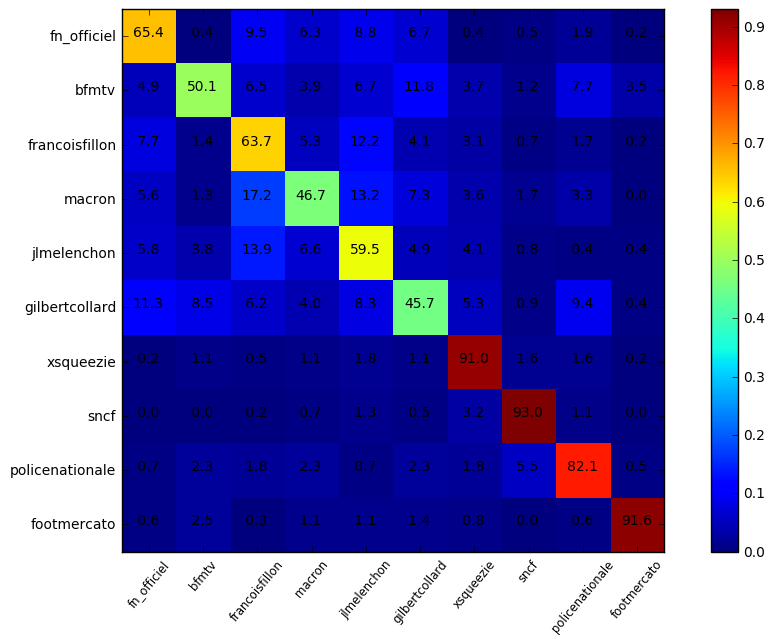

Epoch    3 : 22758.46   Test accuracy: 52.43 69.23 58.96 55.59 58.77 58.96 58.46 69.81 
Epoch    3 : 22449.17   Test accuracy: 52.58 69.36 58.75 55.74 58.69 58.94 58.48 69.94 
Epoch    3 : 22162.28   Test accuracy: 52.49 69.48 58.98 55.76 58.92 59.02 58.44 70.04 
Epoch    3 : 21895.45   Test accuracy: 52.64 69.67 58.94 55.70 59.00 59.15 58.42 70.31 
Epoch    3 : 21646.33   Test accuracy: 52.60 69.92 58.92 55.74 58.90 59.09 58.44 70.46 
Epoch    3 : 21412.72   Test accuracy: 52.68 69.92 59.11 55.74 59.00 59.13 58.63 70.44 
Epoch    3 : 21192.63   Test accuracy: 52.49 70.04 59.13 55.76 58.96 59.29 58.69 70.44 
Epoch    3 : 20984.27   Test accuracy: 52.45 70.04 59.15 55.78 59.04 59.38 58.77 70.50 
Epoch    3 : 20786.08   Test accuracy: 52.35 70.06 59.13 55.78 59.04 59.33 58.71 70.56 
Epoch    3 : 20596.66   Test accuracy: 52.35 70.23 59.29 55.97 59.11 59.25 58.50 70.71 
---------------------------------------------------------------------------------
| 67.2% |  0.7% |  9.5% |  6.5% |  7.5

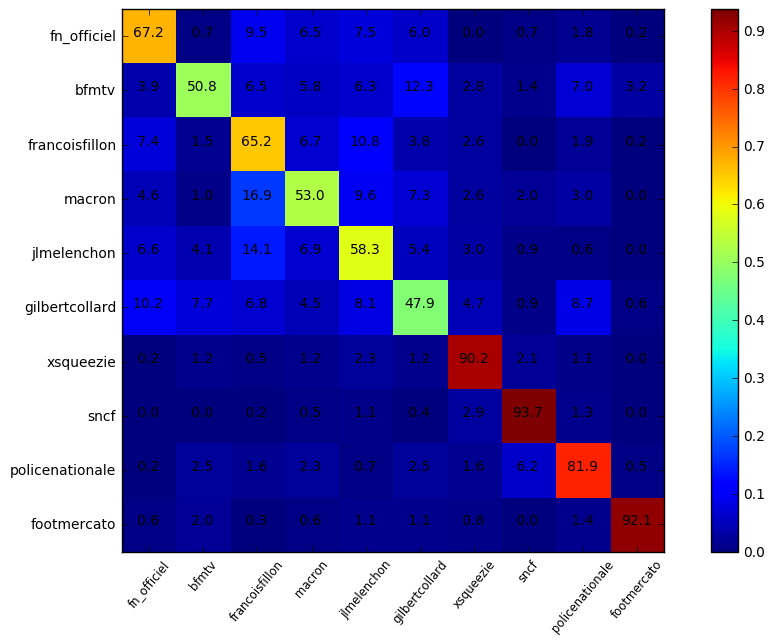

In [14]:
tf.reset_default_graph()
t = LSTM_wrapper('dataset/tweets/data/allnew')

t.show_training(4,10)
t.confusion()
t.show_training(4,10)
t.confusion()

Epoch    3 : 42870.24   Test accuracy: 38.97 54.43 43.75 41.16 43.60 43.89 43.47 54.78 
Epoch    3 : 39415.10   Test accuracy: 41.97 57.23 47.09 44.34 46.90 47.32 46.44 57.73 
Epoch    3 : 37791.06   Test accuracy: 43.20 58.36 48.58 45.73 48.37 48.87 47.76 58.74 
Epoch    3 : 36754.68   Test accuracy: 43.81 58.98 49.34 46.40 49.22 49.42 48.75 59.56 
Epoch    3 : 35987.31   Test accuracy: 44.33 59.57 49.69 46.85 49.68 49.91 49.19 59.98 
Epoch    3 : 35369.06   Test accuracy: 44.75 59.83 50.20 47.21 50.10 50.49 49.61 60.68 
Epoch    3 : 34845.28   Test accuracy: 44.84 60.23 50.39 47.47 50.28 50.57 49.68 60.86 
Epoch    3 : 34387.28   Test accuracy: 44.88 60.61 50.54 47.59 50.39 50.78 49.81 61.04 
Epoch    3 : 33977.38   Test accuracy: 45.09 60.93 50.62 47.65 50.53 50.79 50.03 61.38 
Epoch    3 : 33612.62   Test accuracy: 45.17 60.89 50.78 47.76 50.57 50.98 50.14 61.63 
------------------------------------------------------------------------------------------------------------------------

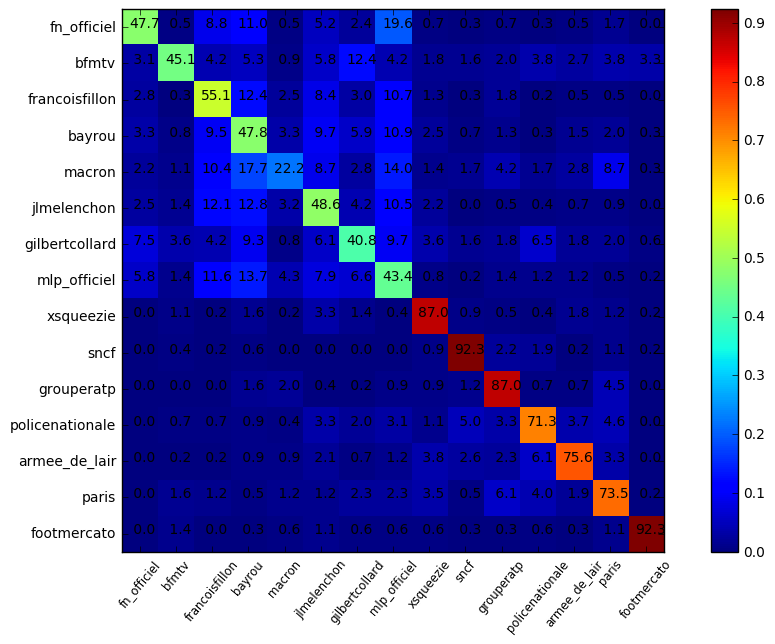

Epoch    3 : 33282.92   Test accuracy: 45.38 61.14 50.95 47.91 50.81 51.11 50.27 61.77 
Epoch    3 : 32981.09   Test accuracy: 45.59 61.03 51.19 48.20 51.11 51.40 50.43 61.83 
Epoch    3 : 32704.46   Test accuracy: 45.73 61.13 51.31 48.33 51.27 51.63 50.49 61.87 
Epoch    3 : 32447.54   Test accuracy: 45.72 61.28 51.44 48.47 51.29 51.63 50.53 61.85 
Epoch    3 : 32206.76   Test accuracy: 45.66 61.18 51.45 48.45 51.27 51.59 50.74 61.89 
Epoch    3 : 31981.23   Test accuracy: 45.74 61.26 51.36 48.27 51.31 51.53 50.73 61.98 
Epoch    3 : 31769.07   Test accuracy: 45.76 61.33 51.37 48.51 51.28 51.73 50.68 61.84 
Epoch    3 : 31567.46   Test accuracy: 45.76 61.35 51.57 48.45 51.41 51.62 50.78 61.94 
Epoch    3 : 31377.94   Test accuracy: 45.77 61.39 51.52 48.62 51.50 51.61 50.87 62.01 
Epoch    3 : 31197.68   Test accuracy: 45.81 61.35 51.54 48.60 51.55 51.69 50.87 61.90 
------------------------------------------------------------------------------------------------------------------------

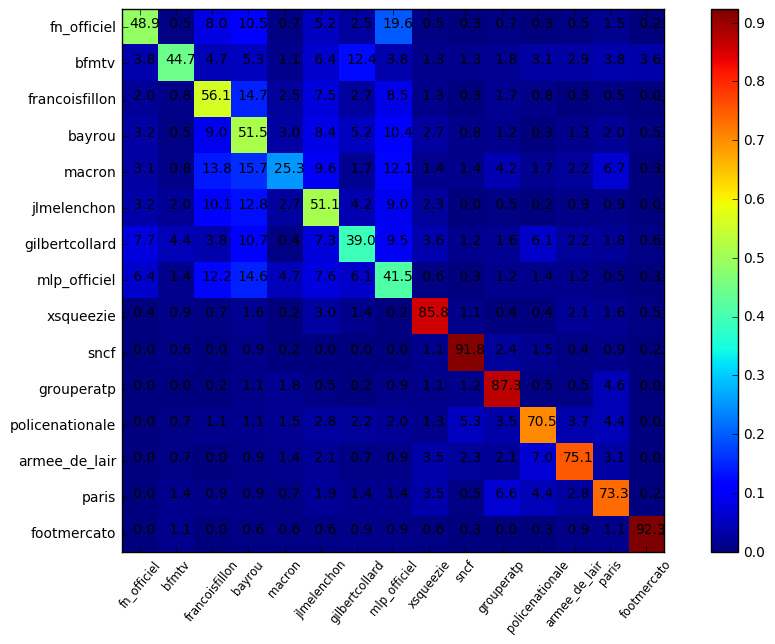

In [13]:

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,7)

tf.reset_default_graph()
t = LSTM_wrapper('dataset/tweets/data/allmorenew')

t.show_training(4,10)
t.confusion()
t.show_training(4,10)
t.confusion()

Epoch    3 : 17317.10   Test accuracy: 63.19 79.62 68.35 66.02 68.25 68.32 68.00 80.04 
Epoch    3 : 15069.38   Test accuracy: 63.96 80.95 69.47 66.85 69.40 69.68 69.09 81.54 
Epoch    3 : 14121.20   Test accuracy: 64.13 81.23 69.57 66.92 69.47 69.71 69.23 81.65 
Epoch    3 : 13471.75   Test accuracy: 64.41 81.54 69.71 67.24 69.75 69.96 69.71 81.75 
Epoch    3 : 12954.83   Test accuracy: 64.62 81.58 70.03 67.62 70.06 70.20 69.85 81.86 
Epoch    3 : 12508.75   Test accuracy: 64.79 81.89 70.34 67.83 70.31 70.59 70.10 82.07 
Epoch    3 : 12107.63   Test accuracy: 65.04 81.89 70.45 67.90 70.38 70.59 70.24 82.10 
Epoch    3 : 11738.30   Test accuracy: 65.04 82.03 70.52 67.93 70.55 70.73 70.48 82.41 
Epoch    3 : 11390.31   Test accuracy: 65.07 82.03 70.62 67.93 70.62 70.62 70.48 82.55 
Epoch    3 : 11055.34   Test accuracy: 65.21 81.79 70.59 68.11 70.55 70.73 70.31 82.34 
-------------------------------------------------
| 75.5% | 13.8% |  7.7% |  1.7% |  0.7% |  0.7% |   Total: 587
-------

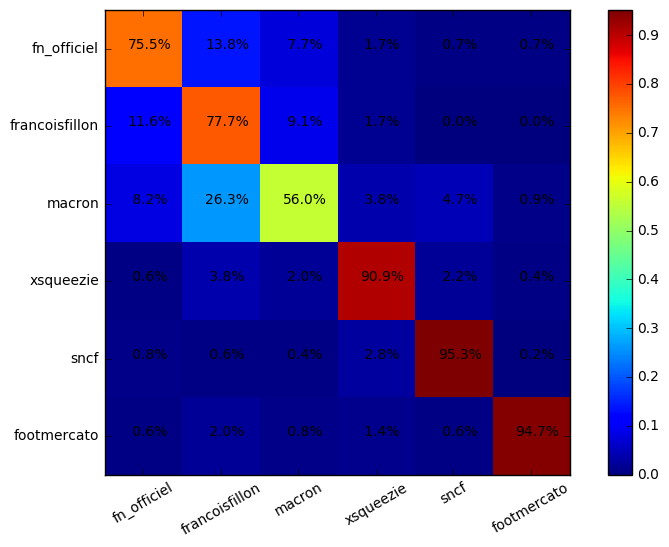

Epoch    3 : 10730.44   Test accuracy: 65.14 82.03 70.41 67.93 70.48 70.62 70.10 82.62 
Epoch    3 : 10415.77   Test accuracy: 65.04 81.89 70.48 67.90 70.34 70.66 69.99 82.52 
Epoch    3 : 10110.68   Test accuracy: 64.90 81.86 70.20 67.59 70.10 70.38 69.61 82.66 
Epoch    3 : 9818.88   Test accuracy: 64.69 82.03 70.13 67.45 69.99 70.13 69.64 82.80 
Epoch    3 : 9541.59   Test accuracy: 64.76 82.00 69.92 67.41 69.82 69.92 69.54 82.62 
Epoch    3 : 9277.87   Test accuracy: 64.55 82.31 69.61 67.13 69.61 69.75 69.40 82.59 
Epoch    3 : 9026.09   Test accuracy: 64.31 82.55 69.61 67.13 69.50 69.71 69.33 82.52 
Epoch    3 : 8783.94   Test accuracy: 64.31 82.38 69.64 67.20 69.61 69.78 69.16 82.66 
Epoch    3 : 8553.37   Test accuracy: 64.17 82.41 69.75 67.10 69.61 69.78 69.26 82.66 
Epoch    3 : 8334.40   Test accuracy: 64.17 82.34 69.50 66.96 69.36 69.61 69.33 82.80 
-------------------------------------------------
| 71.9% | 16.7% |  8.5% |  1.9% |  0.7% |  0.3% |   Total: 587
--------------

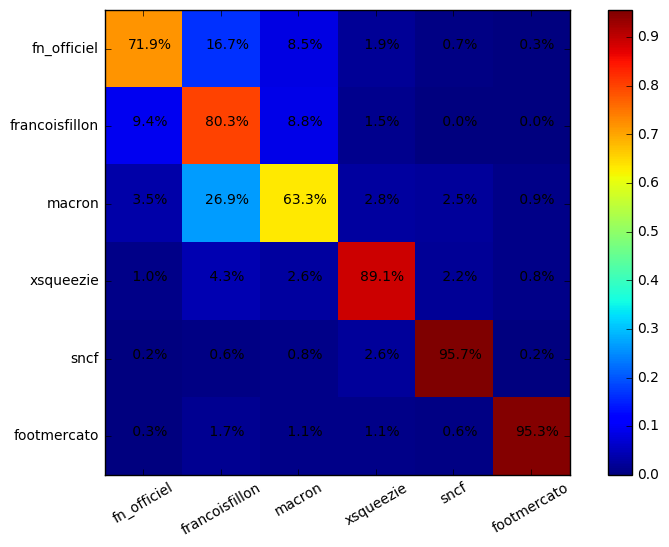

In [547]:
t.show_training(4,10)
t.confusion()
t.show_training(4,10)
t.confusion()

-------------------------
| 78.0% | 16.1% |  5.9% |   Total: 880
-------------------------
| 17.9% | 68.9% | 13.2% |   Total: 927
-------------------------
| 11.2% | 27.4% | 61.5% |   Total: 493


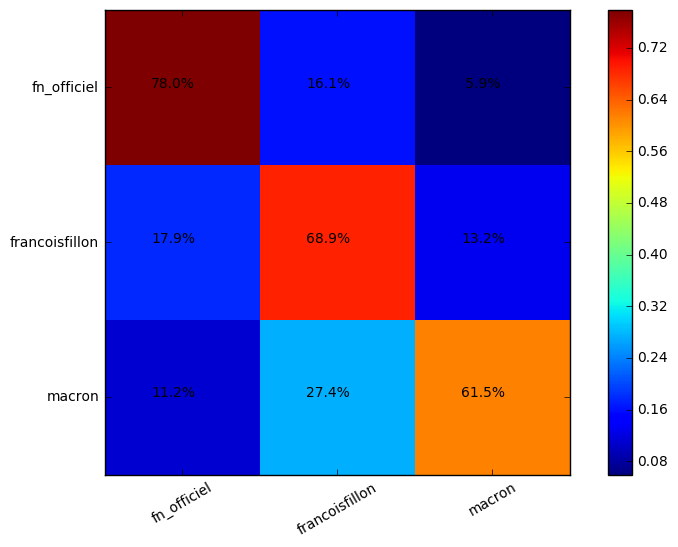

In [379]:
t.confusion()

Epoch    3 : 5542.18   Test accuracy: 68.50 66.16 68.24 67.72 68.02 68.37 67.24 
Epoch    3 : 5214.32   Test accuracy: 70.28 67.33 70.06 69.71 69.97 70.49 69.11 
Epoch    3 : 5046.39   Test accuracy: 71.58 68.33 71.27 70.97 71.27 71.75 70.32 
Epoch    3 : 4923.43   Test accuracy: 72.31 69.67 72.57 71.92 72.10 72.66 71.14 
Epoch    3 : 4828.94   Test accuracy: 72.44 70.28 72.96 72.40 72.70 73.05 71.58 
Epoch    3 : 4753.93   Test accuracy: 72.66 70.49 73.09 72.66 72.92 73.35 72.14 
Epoch    3 : 4691.77   Test accuracy: 72.83 70.84 73.61 73.01 73.35 73.96 72.62 
Epoch    3 : 4638.40   Test accuracy: 73.05 71.14 73.44 72.88 73.18 73.79 72.62 
Epoch    3 : 4591.26   Test accuracy: 73.27 71.06 73.70 72.92 73.53 73.83 72.83 
Epoch    3 : 4548.66   Test accuracy: 73.22 71.32 73.48 72.96 73.31 73.61 72.88 
-------------------------
| 77.0% | 17.8% |  5.2% |   Total: 882
-------------------------
| 13.4% | 77.8% |  8.8% |   Total: 928
-------------------------
|  9.8% | 30.3% | 59.8% |   Total:

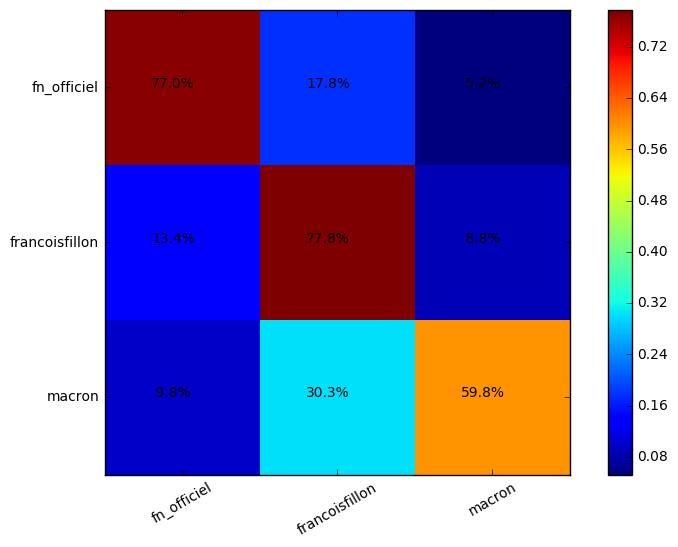

Epoch    3 : 4509.43   Test accuracy: 73.14 71.53 73.53 72.88 73.27 73.74 72.83 
Epoch    3 : 4472.74   Test accuracy: 73.27 71.40 73.61 73.09 73.70 74.00 72.79 
Epoch    3 : 4438.02   Test accuracy: 73.40 71.49 73.70 73.18 73.70 74.09 73.05 
Epoch    3 : 4404.89   Test accuracy: 73.57 71.71 74.13 73.53 73.92 74.22 73.35 
Epoch    3 : 4373.05   Test accuracy: 73.70 71.97 74.31 73.61 73.87 74.39 73.40 
Epoch    3 : 4342.28   Test accuracy: 73.44 71.97 74.13 73.61 73.87 74.31 73.40 
Epoch    3 : 4312.41   Test accuracy: 73.22 71.97 74.00 73.48 73.74 74.18 73.01 
Epoch    3 : 4283.35   Test accuracy: 73.35 72.05 73.96 73.18 73.83 74.22 73.14 
Epoch    3 : 4255.03   Test accuracy: 73.48 72.05 74.09 73.22 74.13 74.09 73.09 
Epoch    3 : 4227.36   Test accuracy: 73.66 72.14 74.18 73.35 74.31 74.26 73.18 
-------------------------
| 78.3% | 16.6% |  5.1% |   Total: 882
-------------------------
| 12.9% | 77.4% |  9.7% |   Total: 928
-------------------------
|  9.2% | 29.5% | 61.2% |   Total:

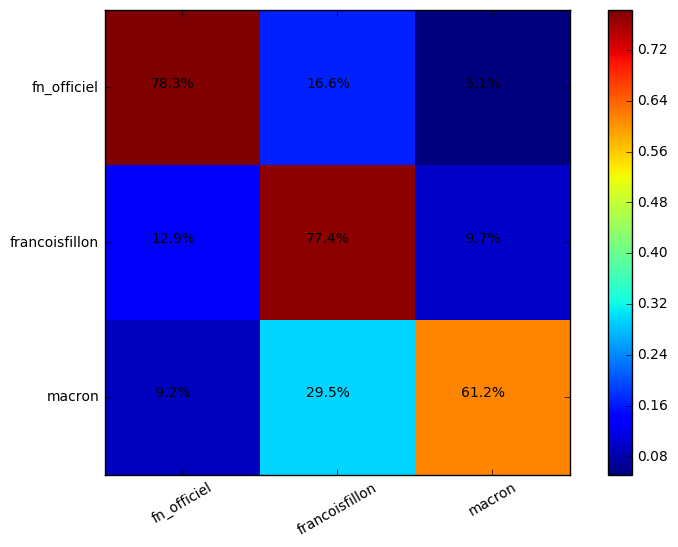

In [520]:
t.show_training(4,10)
t.confusion()
t.show_training(4,10)
t.confusion()

Epoch   49 : 294.28     14.925215     19.18
Epoch   49 : 222.22     11.148828     19.35
Epoch   49 : 151.59     7.075422     17.78
Epoch   49 : 89.81     5.367561     18.63
Epoch   49 : 49.87     3.309643     19.35
Epoch   49 : 35.12     2.217036     19.86
Epoch   49 : 19.12     2.036703     19.30

--------------------------------------------------------

Epoch   49 : 205.19     10.045614     17.78
Epoch   49 : 109.84     4.890209     17.23
Epoch   49 : 47.77     2.036703     17.56
Epoch   49 : 22.31     1.463880     18.67
Epoch   49 : 14.04     1.007744     18.50
Epoch    4 : 13.15

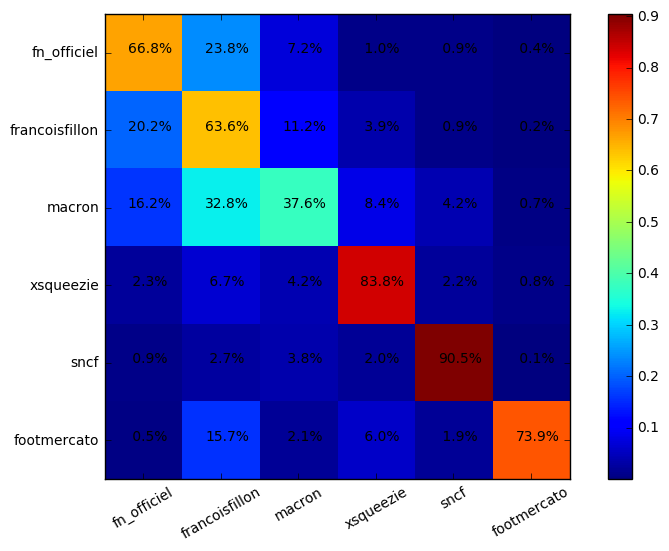

In [276]:
confusion_plot(c,['fn_officiel','francoisfillon','macron','xsqueezie','sncf','footmercato'])